## Deep Convolutional Generative Adversarial Network(DCGAN) on CIFAR10 dataset



#### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.17.1'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bpw7y420
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-bpw7y420
  Resolved https://github.com/tensorflow/docs to commit bbc0b9c70fc0bd4411793d1b0bcc56ef1dbc2405
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.11.18.43811-py3-none-any.whl size=182608 sha256=8c7bd3c75ae6b99f5b379cfea259231b287571335b504c7751f83693bae83e9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0486h46/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


#### Importing required libraries

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

#### Loading and preparing the dataset

Using CIFAR10 dataset to train the generator and the discriminator. The generator will generate images resembling the CIFAR10 images.

CIFAR-10 is a widely used dataset for image classification and machine learning research. It contains 60,000 32x32 colour images in 10 classes, with 6,000 images per class. The dataset is split into 50,000 training images and 10,000 test images.


The dataset includes the following 10 classes:



*  Airplane
*  Automobile

*  Bird
*   Cat
*  Deer

*   Dog
* Frog
*  Horse
*  Ship
*  Truck











In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
# train_images and train_labels contain the training images and their respective labels
# The test data is also loaded, but in this example, it's ignored (assigned to _)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


##### CIFAR10 dataset has 32x32 color images(3 channels[RGB]).Each image has shape(32,32,3)

In [5]:
print(train_images.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [6]:
# train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizing the images to [-1, 1]

##### When training models, data needs to be continuously fed to the GPU or CPU. If data loading is slow, it can bottleneck the training process. Buffering helps by preloading a certain amount of data into memory, allowing the training process to proceed smoothly without waiting for data to be loaded from disk.

- **Loading the dataset**: Retrieves the entire data into memory.
- **Buffering**: Optimizes how data is accessed and shuffled during training for performance improvements.


In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffling the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creating the models

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Starting with a `Dense` layer that takes this seed as input, then upsample several times until it reachs the desired image size of 32x32x3. The `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

#### Leaky ReLU:

##### Outputs 'x' for positive inputs
##### Outputs '0.01 * x' for negative inputs

##### Prevents the "dying neuron" problem where some neurons become inactive during training

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()


     # Input Layer to specify input shape
    model.add(layers.InputLayer(shape=[100,]))  # random vector of shape(100,)

    # Step 1: Dense Layer
    model.add(layers.Dense(8*8*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Step 2: Reshape to (8, 8, 256)
    model.add(layers.Reshape((8, 8, 256)))

    # Step 3: First Transposed Convolution (Upsampling to 8x8x128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Step 4: Second Transposed Convolution (Upsampling to 16x16x64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Step 5: Third Transposed Convolution (Upsampling to 32x32x3 for CIFAR-10)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    # CIFAR-10 output is (32, 32, 3)
    assert model.output_shape == (None, 32, 32, 3)

    return model


Use the (as yet untrained) generator to create an image.

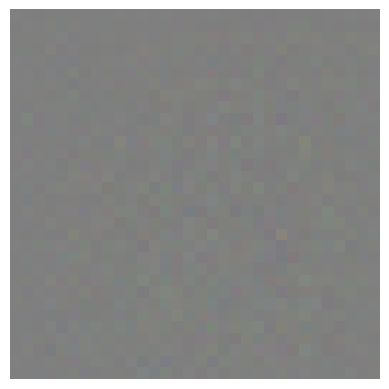

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming make_generator_model() is defined elsewhere
generator = make_generator_model()

# Generating random noise vector (latent vector) for the generator
noise = tf.random.normal([1, 100])

# Generating the image from the noise
generated_image = generator(noise, training=False)

# Normalizing the image from [-1, 1] to [0, 255] for visualization
generated_image = (generated_image + 1) * 127.5

# Converting the tensor to uint8 for proper visualization
generated_image = generated_image.numpy().astype('uint8')

# Displaying the generated image
# For CIFAR-10, the shape should be (32, 32, 3)
plt.imshow(generated_image[0])  # Display the first (and only) image in the batch
plt.axis('off')  # Turn off axis
plt.show()

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Use Input Layer to specify input shape
    model.add(layers.InputLayer(shape=[32, 32, 3]))  # CIFAR-10 input shape (32x32 RGB)

    # First Convolutional Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second Convolutional Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output before feeding into Dense Layer
    model.add(layers.Flatten())

    # Final Dense Layer for classification (real/fake)
    model.add(layers.Dense(1))  # Sigmoid will be applied later in the loss function

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-24.396791]], shape=(1, 1), dtype=float32)


#### The discriminator is not yet trained so the output can be random guess

## Defining the loss and optimizers




In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Defining the training loop


In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# we will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Store the loss values for plotting
gen_losses = []
disc_losses = []

In [ ]:
# The use of `tf.function` annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
    min_gen_loss = float('inf')
    min_disc_loss = float('inf')

    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = 0
        epoch_disc_loss = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss

        # Storing the average loss for the epoch
        avg_gen_loss = epoch_gen_loss / len(dataset)
        avg_disc_loss = epoch_disc_loss / len(dataset)

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        # Tracking minimum losses
        if avg_gen_loss < min_gen_loss:
            min_gen_loss = avg_gen_loss
        if avg_disc_loss < min_disc_loss:
            min_disc_loss = avg_disc_loss

        # Producing images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Saving the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    return gen_losses, disc_losses, min_gen_loss, min_disc_loss

**Generate and save images**


In [ ]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_input):
    # Generating predictions using the model
    predictions = model(test_input, training=False)

    # Converting from [-1, 1] to [0, 255] for visualization
    predictions = (predictions + 1) * 127.5  # Rescale to [0, 255]

    # Set a larger figure size for better visualization
    fig = plt.figure(figsize=(4, 4))  # Adjust the size to your preference

    # Plotting the generated images
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i].numpy().astype('uint8'))
        plt.axis('off')

    # Save the generated images to a file with high resolution
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch), dpi=300)  # Increase dpi for better quality
    plt.show()

## Training the model
Calling the `train()` method defined above to train the generator and discriminator simultaneously.

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about all epochs, they resemble CIFAR10 images.

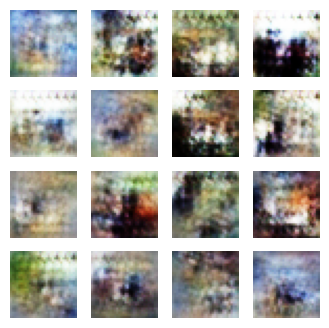

In [ ]:
# Train the model
gen_losses, disc_losses, min_gen_loss, min_disc_loss = train(train_dataset, EPOCHS)

#### For 100 epochs


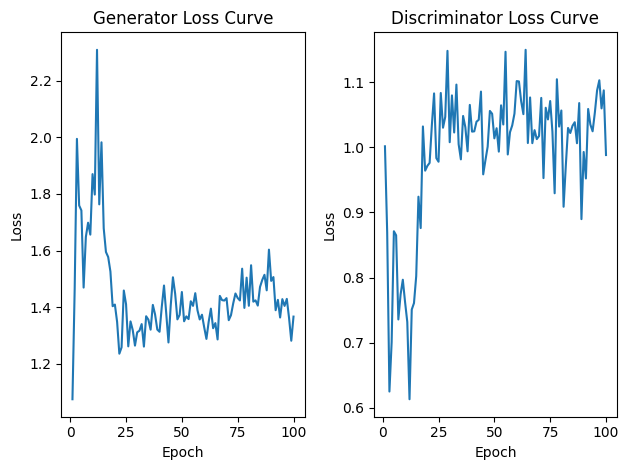

Minimum Generator Loss: 1.074680209159851
Minimum Discriminator Loss: 0.6132917404174805


In [ ]:
# Generator Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), gen_losses, label='Generator Loss')
plt.title('Generator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Discriminator Loss Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), disc_losses, label='Discriminator Loss')
plt.title('Discriminator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Output the minimum observed losses
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")

In [ ]:
# After initial training for 100 epochs, restoring the checkpoint
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

## Creating a GIF


In [ ]:
# Displaying a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

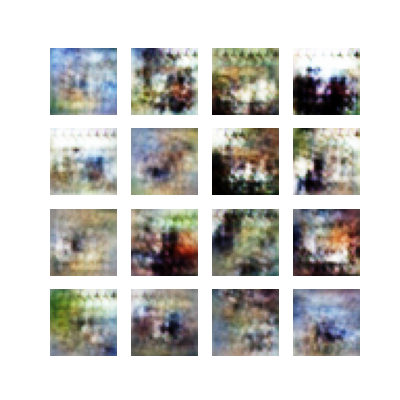

In [ ]:
display_image(EPOCHS)

Using `imageio` to create an animated gif using the images saved during training.

In [ ]:
import imageio.v2 as imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


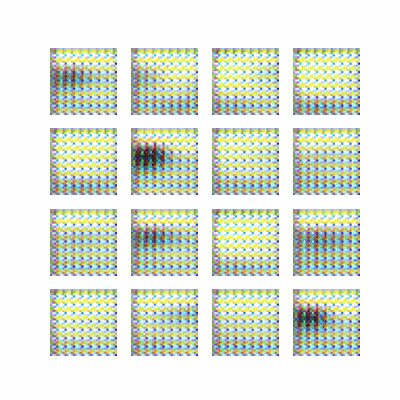

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

---
---

#### Adding one additional convolutional layer in the discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Use Input Layer to specify input shape
    model.add(layers.InputLayer(shape=[32, 32, 3]))  # CIFAR-10 input shape (32x32 RGB)

    # First Convolutional Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second Convolutional Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third Convolutional Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output before feeding into Dense Layer
    model.add(layers.Flatten())

    # Final Dense Layer for classification (real/fake)
    model.add(layers.Dense(1))  # Sigmoid will be applied later in the loss function

    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-11.76144]], shape=(1, 1), dtype=float32)


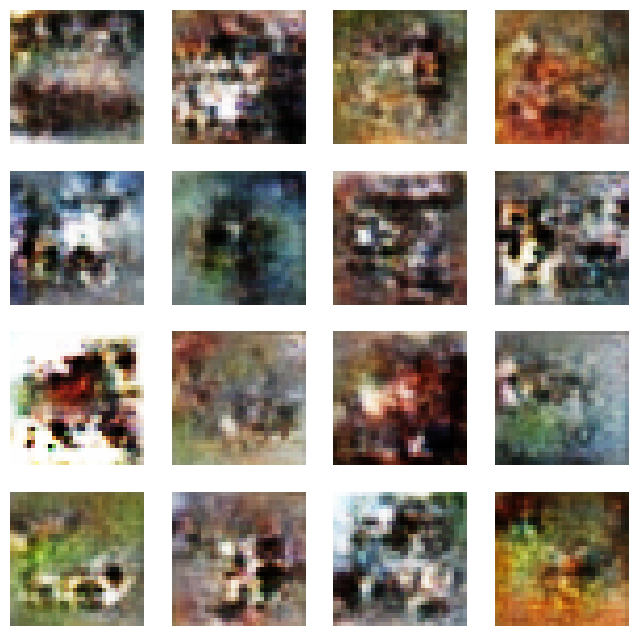

In [ ]:
# Train the model
gen_losses, disc_losses, min_gen_loss, min_disc_loss = train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

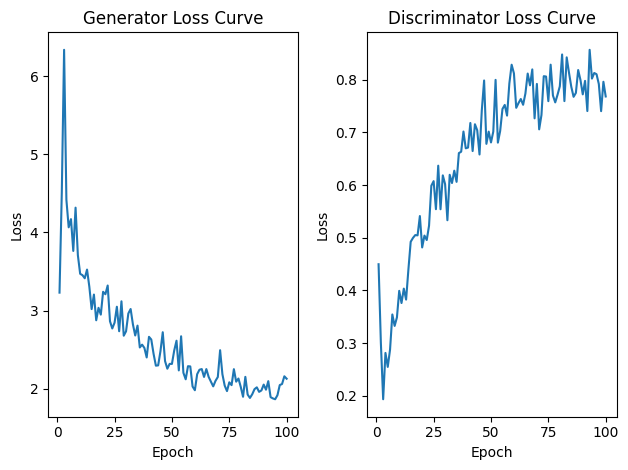

Minimum Generator Loss: 1.86485755443573
Minimum Discriminator Loss: 0.19333113729953766


In [ ]:
import matplotlib.pyplot as plt
# Generator Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), gen_losses, label='Generator Loss')
plt.title('Generator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Discriminator Loss Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), disc_losses, label='Discriminator Loss')
plt.title('Discriminator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Output the minimum observed losses
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")




### **1. Initial Configuration**
- **Minimum Generator Loss**: `1.0747`
- **Minimum Discriminator Loss**: `0.6133`

This suggests a reasonably balanced training:
- The discriminator is doing a fair job of distinguishing between real and fake images (loss close to `0.5`).
- The generator is making progress (relatively lower loss) in producing images that can fool the discriminator.

---

### **2. After Adding a Convolutional Layer**
- **Minimum Generator Loss**: `1.8649`
- **Minimum Discriminator Loss**: `0.1933`

This indicates a significant shift:
- **Generator Loss Increase**: The generator is struggling more to fool the discriminator. A higher loss suggests that the discriminator has become more effective at identifying fake images.
- **Discriminator Loss Decrease**: A lower loss (close to zero) indicates that the discriminator is too strong and overfitting to the training data. It is likely over-penalizing the generator.

---



- **Not ideal**: The added convolutional layer has made the discriminator too powerful, leading to an imbalance in training. The generator cannot keep up, resulting in weaker generated images.
- GANs require a **balanced interplay** between the generator and discriminator. If one model (in this case, the discriminator) becomes too strong, it hinders the overall progress of the GAN.

---


1. **Regularizing the Discriminator**:
   - Using **Dropout** (changing the dropout of the discriminator)
   

2. **Strengthening the Generator**:
   - Adding additional layers or filters to the generator to help it compete with the more powerful discriminator.




3. **Adjust Hyperparameters**:
   - Fine-tuning the learning rates for both the generator and discriminator.
   - Lower the discriminator's learning rate slightly (e.g., to `1e-5`) to slow down its progress relative to the generator.






Adding the convolutional layer made the discriminator too strong, leading to unbalanced training.

---
---

#### Decreasing the dropout of discriminator from 0.3 to 0.2

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Use Input Layer to specify input shape
    model.add(layers.InputLayer(shape=[32, 32, 3]))  # CIFAR-10 input shape (32x32 RGB)

    # First Convolutional Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Second Convolutional Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Third Convolutional Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Flatten the output before feeding into Dense Layer
    model.add(layers.Flatten())

    # Final Dense Layer for classification (real/fake)
    model.add(layers.Dense(1))  # Sigmoid will be applied later in the loss function

    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-6.628334]], shape=(1, 1), dtype=float32)


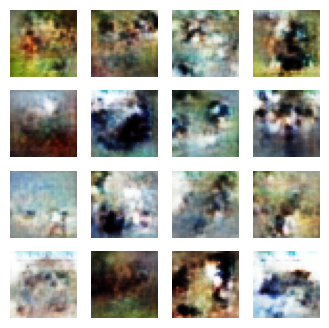

In [ ]:
# Train the model
gen_losses, disc_losses, min_gen_loss, min_disc_loss = train(train_dataset, EPOCHS)

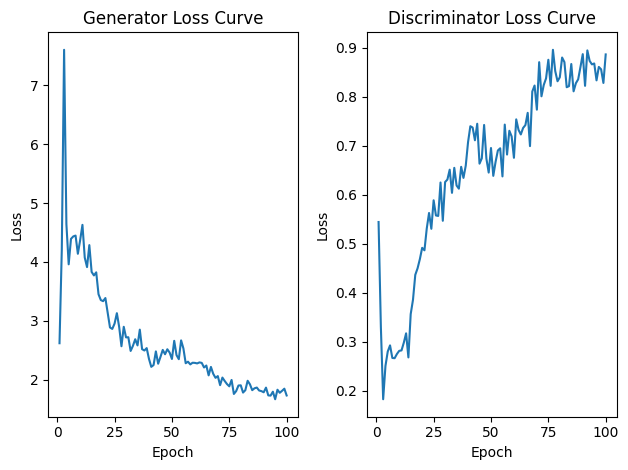

Minimum Generator Loss: 1.670793056488037
Minimum Discriminator Loss: 0.1821645200252533


In [ ]:
import matplotlib.pyplot as plt
# Generator Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), gen_losses, label='Generator Loss')
plt.title('Generator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Discriminator Loss Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), disc_losses, label='Discriminator Loss')
plt.title('Discriminator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Output the minimum observed losses
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")

---
---
Removing additional conv layer in the discriminator and setting dropout to 0.2

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Use Input Layer to specify input shape
    model.add(layers.InputLayer(shape=[32, 32, 3]))  # CIFAR-10 input shape (32x32 RGB)

    # First Convolutional Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Second Convolutional Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # # Third Convolutional Layer
    # model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # Flatten the output before feeding into Dense Layer
    model.add(layers.Flatten())

    # Final Dense Layer for classification (real/fake)
    model.add(layers.Dense(1))  # Sigmoid will be applied later in the loss function

    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-43.740185]], shape=(1, 1), dtype=float32)


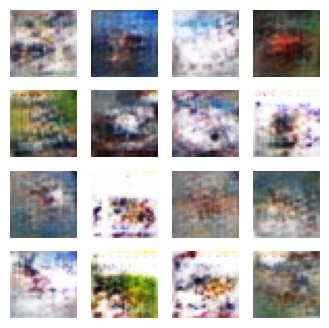

In [ ]:
# Training the model
gen_losses, disc_losses, min_gen_loss, min_disc_loss = train(train_dataset, EPOCHS)

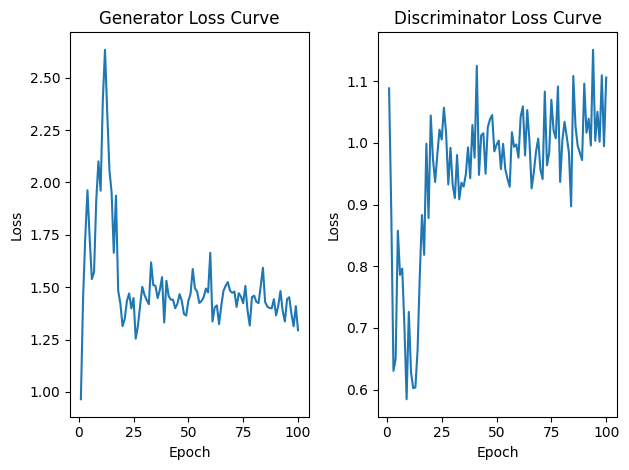

Minimum Generator Loss: 0.9650923013687134
Minimum Discriminator Loss: 0.5844624042510986


In [ ]:
import matplotlib.pyplot as plt
# Generator Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), gen_losses, label='Generator Loss')
plt.title('Generator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Discriminator Loss Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), disc_losses, label='Discriminator Loss')
plt.title('Discriminator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Output the minimum observed losses
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")

#### The discriminator loss is around 0.58, which denotes a fairly good discriminator

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


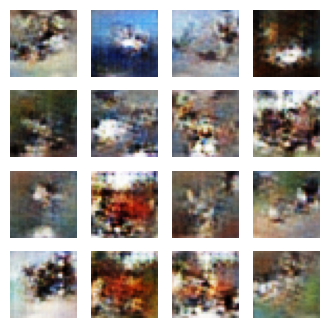

In [ ]:
# Training the model
gen_losses, disc_losses, min_gen_loss, min_disc_loss = train(train_dataset, EPOCHS)

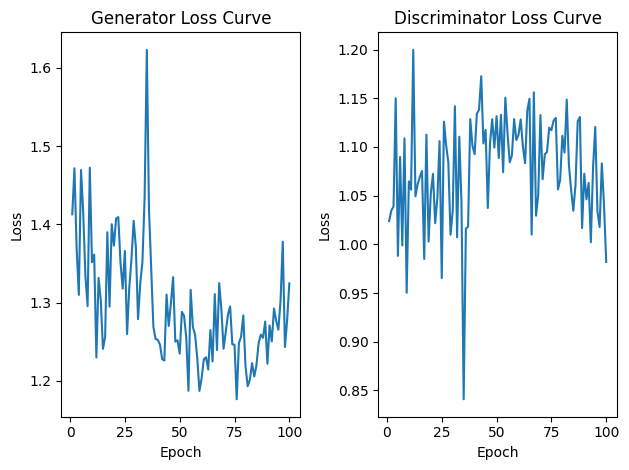

Minimum Generator Loss: 1.1763525009155273
Minimum Discriminator Loss: 0.8409652709960938


In [ ]:
import matplotlib.pyplot as plt
# Generator Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), gen_losses[100:], label='Generator Loss')
plt.title('Generator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Discriminator Loss Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), disc_losses[100:], label='Discriminator Loss')
plt.title('Discriminator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Output the minimum observed losses
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")

### Dropout = 0.5

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Use Input Layer to specify input shape
    model.add(layers.InputLayer(shape=[32, 32, 3]))  # CIFAR-10 input shape (32x32 RGB)

    # First Convolutional Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second Convolutional Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # # Third Convolutional Layer
    # model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    # Flatten the output before feeding into Dense Layer
    model.add(layers.Flatten())

    # Final Dense Layer for classification (real/fake)
    model.add(layers.Dense(1))  # Sigmoid will be applied later in the loss function

    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-6.048763]], shape=(1, 1), dtype=float32)


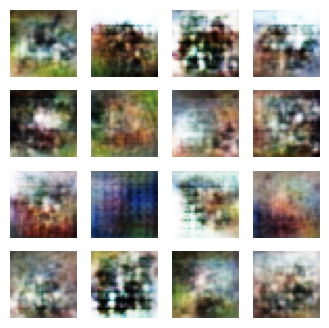

In [ ]:
# Training the model
gen_losses, disc_losses, min_gen_loss, min_disc_loss = train(train_dataset, EPOCHS)

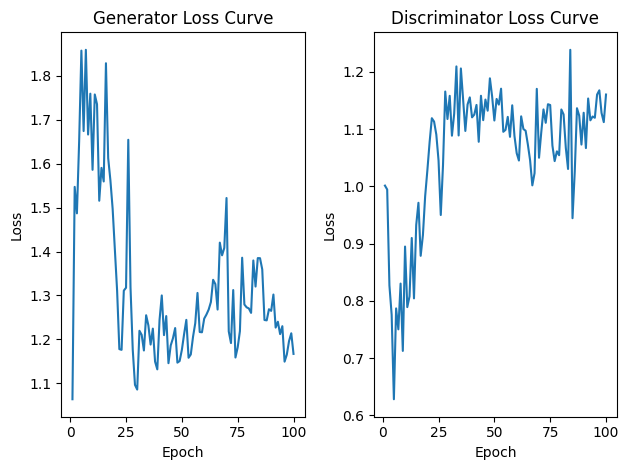

Minimum Generator Loss: 1.0638450384140015
Minimum Discriminator Loss: 0.6279712319374084


In [ ]:
import matplotlib.pyplot as plt
# Generator Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), gen_losses, label='Generator Loss')
plt.title('Generator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Discriminator Loss Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), disc_losses, label='Discriminator Loss')
plt.title('Discriminator Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Output the minimum observed losses
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")